## Task #2 
### Predicting subsriber's internet traffic usage in 6 months

In [1]:
import pandas as pd
import numpy as np
import lightgbm as ltb
import re


from scipy.stats import linregress
import scipy.linalg

from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder 
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)


In [2]:
# # # DEFINING PRIMARY FOLDER LOCATION PATH FOR FURTHER USAGE

dir_path = 'C:/Users/Edward/Documents/Appleolga/Final_pro/model2/'
# dir_path = 'C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/'

### 1. DATA PREPROCESSING

#### 1.1 Combining data sources and initial data cleaning

In [3]:
# # # READING INITIAL TRAIN DATA
data_traff_train = pd.read_sas(dir_path +'train/hash_school_dpi_model_traff.sas7bdat')
data_train = pd.read_sas(dir_path + 'train/hash_school_dpi_model_fe.sas7bdat')

# # # READING INITIAL TEST DATA
data_traff_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_traff_test.sas7bdat')
data_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_fe_test.sas7bdat')
data_test2 = pd.read_sas(dir_path + 'test/hash_school_dpi_model_test.sas7bdat')

In [4]:
# # # DUPLICATES CLEANING AND MERGING INITIAL DATA FILES

print(data_train.shape)
print(data_traff_train.shape)
data_traff_train = data_traff_train.drop_duplicates()
data_train = data_train.drop_duplicates()
print(data_train.shape)
print(data_traff_train.shape)

data_train = data_train.merge(data_traff_train, on = 'abon_id')
del data_traff_train

print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)
data_test = data_test.drop_duplicates()
data_test2 = data_test2.drop_duplicates()
data_traff_test = data_traff_test.drop_duplicates()
print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)

data_test = data_test.merge(data_test2, on = 'abon_id').merge(data_traff_test, on = 'abon_id')
del data_test2
del data_traff_test

data_train = data_train.astype('float32')
data_test = data_test.astype('float32')

(250043, 906)
(249967, 6)
(250026, 906)
(249955, 6)
(243150, 905)
(243150, 2)
(243085, 6)
(243123, 905)
(243061, 2)
(243061, 6)


In [5]:
# # # PARTIAL DUPLICATES CLEANING

duplicates = list(data_train['abon_id'].value_counts().where(lambda x: x > 1).dropna().index)
data_train_duplicates = data_train.loc[data_train['abon_id'].isin(duplicates), :]
data_train_duplicates_f = data_train_duplicates[data_train_duplicates.duplicated(subset='abon_id', 
                                                                                 keep='first')].set_index('abon_id')
data_train_duplicates_l = data_train_duplicates[data_train_duplicates.duplicated(subset='abon_id', 
                                                                                 keep='last')].set_index('abon_id')
print(data_train_duplicates_f.compare(data_train_duplicates_l, align_axis = 1))

print(data_train.shape)
data_train = data_train.drop(set(data_train_duplicates.index))
print(data_train.shape)

del duplicates, data_train_duplicates, data_train_duplicates_f,data_train_duplicates_l

          bs_delte_ppd_change_tp       
                            self  other
abon_id                                
1471973.0                  0.000  0.008
1735334.0                  0.027  0.125
1735340.0                  0.027  0.125
1735408.0                  0.000  0.008
1735443.0                  0.000  0.008
1735501.0                  0.027  0.125
1735518.0                  0.027  0.125
1735531.0                  0.027  0.125
1735610.0                  0.000  0.008
1735706.0                  0.027  0.125
1735731.0                  0.027  0.125
1735821.0                  0.027  0.125
1736250.0                  0.027  0.125
1736251.0                  0.027  0.125
1756637.0                  0.000  0.008
1756697.0                  0.125  0.027
1757327.0                  0.000  0.008
1762305.0                  0.000  0.008
1762348.0                  0.027  0.125
1762371.0                  0.008  0.000
1762394.0                  0.008  0.000
1762408.0                  0.008  0.000


In [6]:
duplicates = list(data_test['abon_id'].value_counts().where(lambda x: x > 1).dropna().index)
data_test_duplicates = data_test.loc[data_test['abon_id'].isin(duplicates), :]
data_test_duplicates_f = data_test_duplicates[data_test_duplicates.duplicated(subset='abon_id',
                                                                              keep='first')].set_index('abon_id')
data_test_duplicates_l = data_test_duplicates[data_test_duplicates.duplicated(subset='abon_id',
                                                                              keep='last')].set_index('abon_id')
print(data_test_duplicates_f.compare(data_test_duplicates_l, align_axis = 1))

print(data_test.shape)
data_test = data_test.drop(set(data_test_duplicates.index))
print(data_test.shape)

del duplicates, data_test_duplicates, data_test_duplicates_f,data_test_duplicates_l

          bs_delte_ppd_change_tp       
                            self  other
abon_id                                
1735181.0                  0.027  0.125
1735206.0                  0.000  0.008
1735228.0                  0.000  0.008
1735237.0                  0.000  0.008
1735256.0                  0.027  0.125
1735316.0                  0.027  0.125
1735517.0                  0.027  0.125
1735560.0                  0.027  0.125
1735685.0                  0.027  0.125
1735701.0                  0.000  0.008
1735837.0                  0.027  0.125
1735847.0                  0.027  0.125
1735860.0                  0.027  0.125
1736228.0                  0.000  0.008
1748322.0                  0.027  0.125
1756719.0                  0.125  0.027
1762270.0                  0.027  0.125
1762306.0                  0.000  0.008
1762483.0                  0.027  0.125
1762510.0                  0.000  0.008
1767512.0                  0.027  0.125
1767638.0                  0.027  0.125


For partial duplicate records only one columns differs per record and there are only 124 such records both train and test datasets, so it would be safe to just delete them. 

In [9]:
# # # # WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# data_train.to_parquet((dir_path + 'train/data_train.parquet.gzip'),compression='gzip')
# data_test.to_parquet((dir_path + 'test/data_test.parquet.gzip'),compression='gzip')

# # # READING INITIAL MERGED TRAIN AND TEST DATA FROM PARQUET
data_train = pd.read_parquet(dir_path + 'train/data_train.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test.parquet.gzip')

In [13]:
data_train.describe().style.format('{:.2f}')

In [14]:
data_train.isna().sum()

abon_id                                  0
Balance_uah                            704
TM_ID                                  704
lt                                    1817
CALCULATION_METHOD_ID                  704
device_days_usage                    20095
device_brand_samsung                 20095
device_brand_nokia                   20095
device_brand_lenovo                  20095
device_brand_apple                   20095
device_brand_huawei                  20095
device_brand_lg                      20095
device_brand_xiaomi                  20095
device_brand_meizu                   20095
device_brand_prestigio               20095
device_brand_sony                    20095
device_brand_nan                     20095
device_brand_other                   20095
device_android_version              177793
device_ios_version                  223790
device_has_gprs                      20095
device_has_wifi                      20095
device_has_lte                       20095
device_widt

#### 1.2 Data exploration

In [15]:
# TRAFFIC COLUMNS SHOULD BE ONE OF THE MOST IMPORTANT FOR THE MODEL - LET'S EXPLORE THEM
#CHECKING TRAFFIC VARIANCE

traffic_cols = ['traff_m5', 'traff_m4', 'traff_m3','traff_m2','traff_m1']
traff_var = pd.DataFrame(data = data_train[traffic_cols + ['target']].var(), columns = ['traff_var'])
traff_var.style.format("{:.10}")

,traff_var
traff_m5,99.11869049
traff_m4,79474448.0
traff_m3,127.6313858
traff_m2,125.1598282
traff_m1,143.3137665
target,140.9387207


In [16]:
data_train[traffic_cols + ['target']].describe()

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
count,249893.000000,2.498930e+05,249893.000000,249893.000000,249893.000000,249893.000000
mean,4.608354,2.307156e+01,5.673473,5.792874,5.935543,5.748942
std,9.955837,8.914845e+03,11.297406,11.187486,11.971373,11.871761
min,0.000000,0.000000e+00,0.000000,0.004883,0.000000,0.000000
25%,0.040584,1.185213e-01,0.188427,0.324355,0.215193,0.032750
50%,0.991824,1.236080e+00,1.407719,1.583868,1.473335,1.210681
75%,4.332773,5.041143e+00,5.448943,5.611701,5.594293,5.359280
max,1025.197510,4.456472e+06,436.159088,277.037262,640.266663,149.926666


In [17]:
data_train[traffic_cols + ['target']].sort_values(by = 'traff_m4', ascending = False)

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
index,,,,,,
219252,19.389360,4.456472e+06,12.937638,22.850140,5.037920,0.000002
217018,32.776627,2.341316e+02,323.528503,7.150309,57.112225,0.000000
225292,203.641739,1.974701e+02,142.643738,181.878891,112.523209,51.736969
115912,147.485641,1.974000e+02,1.870279,0.976280,1.645507,0.021695
209639,78.837807,1.673304e+02,136.827057,88.402878,0.000019,0.000000
...,...,...,...,...,...,...
97495,2.447521,0.000000e+00,1.095781,1.472506,0.933528,0.000000
18332,0.178172,0.000000e+00,0.361652,0.899875,0.636902,1.659207
97492,0.000000,0.000000e+00,0.000000,0.384816,0.000000,0.006343


In [18]:
data_train[traffic_cols + ['target']].drop(219252).describe()

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
count,249892.000000,249892.000000,249892.000000,249892.000000,249892.000000,249892.000000
mean,4.608295,5.238484,5.673444,5.792806,5.935547,5.748966
std,9.955816,10.567942,11.297422,11.187451,11.971397,11.871780
min,0.000000,0.000000,0.000000,0.004883,0.000000,0.000000
25%,0.040582,0.118511,0.188424,0.324340,0.215191,0.032750
50%,0.991822,1.236037,1.407713,1.583862,1.473334,1.210687
75%,4.332767,5.041022,5.448941,5.611682,5.594333,5.359322
max,1025.197510,234.131577,436.159088,277.037262,640.266663,149.926666


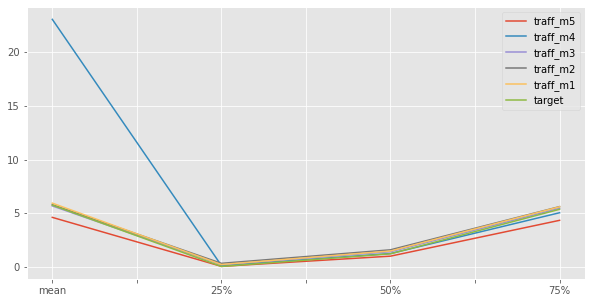

In [19]:
data_train[traffic_cols + ['target']].describe().loc[['mean','25%', '50%', '75%']].plot();

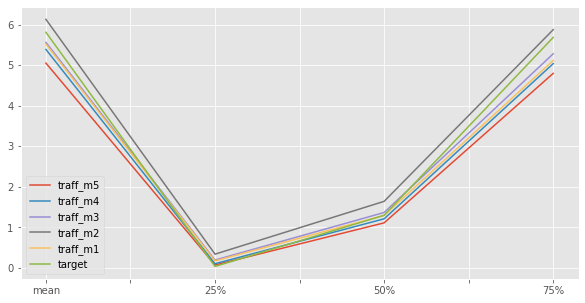

In [36]:
data_test[traffic_cols + ['target']].describe().loc[['mean','25%', '50%', '75%']].plot();

Only one sample in 'traff_m4' is responsible for the general feature variance deviation from the rest. Safe to assume it is an outlier and delete it

In [21]:
data_train = data_train.drop(219252)
print(data_train.shape)

(249892, 911)


In [22]:
#FUNCTION TO FIND CATEGORICAL COLUMNS

def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list

In [23]:
cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

32
879


In [24]:
# FUNCTION TO CREARE AN INFORMATION DATAFRAME TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [25]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask  

In [26]:
data_train_num_outliers_mask = mark_outliers(data_train[num_col_list])
data_train_num_info = df_info(data_train[num_col_list], data_train_num_outliers_mask)
del data_train_num_outliers_mask

100
200
300
400
500
600
700
800


In [27]:
# # # WRITING AND READING DATA_TRAIN_INFO DF TO PARQUET

# data_train_num_info.to_parquet((dir_path + 'data_train_num_info.parquet.gzip'),compression='gzip')

data_train_num_info = pd.read_parquet(dir_path +'data_train_num_info.parquet.gzip')

In [29]:
# # # HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [30]:
# # # PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.4%}"})
data_train_num_info_style

,col,%of_fr_univalue,%of_unfr_univalue,freq_value,%outliers,%nans
216,entertainment,0.00%,nan%,32.533134,0.00%,99.9964%
69,cnt_unq_category_collect,0.01%,nan%,0.000000,0.00%,99.9916%
57,cnt_sms_category_collect,0.00%,0.00%,1.206949,0.00%,99.9916%
122,MV_FRAUD_BLOCK,0.01%,nan%,0.693147,0.00%,99.9912%
217,Food,0.01%,nan%,32.533134,0.00%,99.9904%
45,tsoa_mail_cnt,0.01%,0.00%,0.000000,0.00%,99.9892%
98,cnt_bank_sms_category_radabank,0.00%,0.00%,0.000000,0.00%,99.9644%
95,cnt_bank_sms_category_unexbank,0.01%,0.00%,0.000000,0.00%,99.9604%
93,cnt_bank_sms_category_bisbank,0.01%,0.01%,0.480453,0.00%,99.9528%
44,Fax,0.04%,0.01%,0.000000,0.01%,99.9452%


Target as well traffic features revolve around zero

There are a lot of columns with almsot 100% missing values or 100% missings+univalue columns. Also, a lot of columns have more than 10% outlier values. Classic linear models might not be good  as a basic one for this type of data. 


### 2. Defining base model and base scores

To be able to compare linear and tree-based models, let's take the features with biggest target correlation and compare models' perfomance

In [31]:
data_train_num_corr = data_train[num_col_list].corr()

In [32]:
# # # WRITING AND READING DATA_TRAIN TARGET CORRELATION DF TO PARQUET

# data_train_num_corr.to_parquet((dir_path + 'data_train_num_corr2.parquet.gzip'),compression='gzip')

data_train_num_corr = pd.read_parquet(dir_path +'data_train_num_corr2.parquet.gzip')

In [33]:
# # # ADDING TARGET CORR TO THE INFO DF
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)


In [34]:
data_train_num_corr['target'].median()

0.032820051480194415

Let's single out features, correlated with the target and train different models. 

In order to undestand if target correlation makes any difference let's use progressively shrinking datasets, 
starting from all features, which are correlated with the target more than a median values for this dataset, 
and ending with only the highest correlated feature set.

In [35]:
# # # 

target_corr_f_list = []

for i in np.arange(0.03, 1, 0.01):
    _ = list(data_train_num_info[data_train_num_info['target'] >= i]['col'])
    _.remove('target')
    target_corr_f_list.append(_)
    
    
import itertools
target_corr_f_list = list(k for k,_ in itertools.groupby(target_corr_f_list))

models_res_df = pd.DataFrame(columns = ['Features_No','SLR', 'XGB', 'LGB'])
i = 0

for cols in target_corr_f_list: 
    if len(cols) != 0:
        
        print('Fitting models for {} features'.format(len(cols)))    

        X_train, y_train = data_train[cols].fillna(0), data_train.target
        X_test, y_test = data_test[cols].fillna(0), data_test.target

        # lINEAR REGRESSION
        slr = LinearRegression(normalize=True)
        slr.fit(X_train, y_train)
        y_test_pred = slr.predict(X_test)
        slr_rmse = mean_squared_error(y_test, y_test_pred, squared = False)


        # XGBoost
        xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
        xgb_model.fit(X_train, y_train)
        y_test_pred = xgb_model.predict(X_test)
        xbg_rmse = mean_squared_error(y_test, y_test_pred, squared = False)

        # LightGBM
        lgb_model = ltb.LGBMRegressor(objective ='regression',random_state = 0)
        lgb_model.fit(X_train, y_train)
        y_test_pred = lgb_model.predict(X_test)
        lgb_rmse = mean_squared_error(y_test, y_test_pred, squared = False)

        models_res_df.loc[i, :] = [len(cols), slr_rmse, xbg_rmse, lgb_rmse]
        i +=1
    


Fitting models for 435 features
Fitting models for 407 features
Fitting models for 386 features
Fitting models for 348 features
Fitting models for 313 features
Fitting models for 282 features
Fitting models for 244 features
Fitting models for 213 features
Fitting models for 179 features
Fitting models for 152 features
Fitting models for 137 features
Fitting models for 122 features
Fitting models for 109 features
Fitting models for 99 features
Fitting models for 87 features
Fitting models for 76 features
Fitting models for 67 features
Fitting models for 55 features
Fitting models for 45 features
Fitting models for 42 features
Fitting models for 36 features
Fitting models for 35 features
Fitting models for 34 features
Fitting models for 33 features
Fitting models for 30 features
Fitting models for 26 features
Fitting models for 24 features
Fitting models for 21 features
Fitting models for 15 features
Fitting models for 14 features
Fitting models for 13 features
Fitting models for 12 feat

In [37]:
models_res_df.style.format({'Features_No':'{:}', 'SLR':'{:.4f}', 'XGB':'{:.4f}', 'LGB':'{:.4f}'})

,Features_No,SLR,XGB,LGB
0,435,8.7268,8.8824,8.6577
1,407,8.7272,8.8951,8.6638
2,386,8.7268,8.8641,8.6723
3,348,8.7301,8.8895,8.6650
4,313,8.7328,8.8179,8.6672
5,282,8.7321,8.8468,8.6676
6,244,8.7323,8.8516,8.6622
7,213,8.7339,8.8681,8.6640
8,179,8.7355,8.8589,8.6592
9,152,8.7371,8.8645,8.6653


LightGBM yileds best results. 

What is interesting is that simple linear regression outperforms XGBoost on bigger datasets. 
Also LightGBM works better on bigger datasets

##### Let's use LightGBM Regressor as a base model to define base score on a full dataset and make first check of features importance rates

In [38]:
X_train_full = data_train.drop(['target'], axis = 1).fillna(0)

y_train_full = data_train['target']

X_test_full = data_test.drop(['target'], axis = 1).fillna(0)

y_test_full = data_test['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))


f_importance_df = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

RMSE train: 7.561558, test: 8.653576
R^2 train: 0.594206, test: 0.446898


,importance
traff_m1,163
traff_m5,107
traff_m4,52
non_accum_internet_vol_mea_mnt3,45
traff_m3,33
dpi_upload,33
loc_lon,32
MV_Traf_4G_d_Mb,32
bs_succ_rate,29
non_accum_internet_vol_min_mnt3,27


### 3. Feature filtering and feature generation

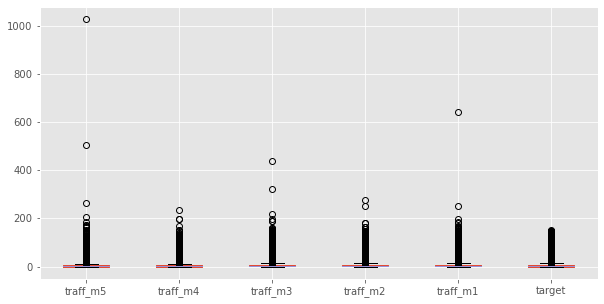

In [40]:
# ## TRAFFIC ALMOST COMPLETELY REVOLVES AROUND ZERO TO ONE VALUES WHILE HAVING BIG TAILS
data_train[traffic_cols + ['target']].plot.box();

In [41]:
# # # LET'S SEE HOW TRAFFIC VALUES ARE DISPERSED

data_train[traffic_cols + ['target']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, .9, 0.95, 0.96, 0.97, 0.98, 0.99])

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
count,249892.000000,249892.000000,249892.000000,249892.000000,249892.000000,249892.000000
mean,4.608295,5.238484,5.673444,5.792806,5.935547,5.748966
std,9.955816,10.567942,11.297422,11.187451,11.971397,11.871780
min,0.000000,0.000000,0.000000,0.004883,0.000000,0.000000
10%,0.000000,0.000000,0.000434,0.050525,0.005271,0.000000
25%,0.040582,0.118511,0.188424,0.324340,0.215191,0.032750
50%,0.991822,1.236037,1.407713,1.583862,1.473334,1.210687
75%,4.332767,5.041022,5.448941,5.611682,5.594333,5.359322
90%,12.986345,14.883238,16.035465,16.148390,16.607210,16.078863
95%,22.660072,25.595793,27.802827,28.044547,29.380591,29.031354


Only 1% of data in each month yield big values. Let's see what these records look like

In [42]:
traff_99p_mean = data_train[traffic_cols + ['target']].describe(percentiles=[0.99]).loc['99%'].mean()
data_train[traffic_cols + ['target']][data_train[traffic_cols].\
                                      applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                      sort_values(by=['traff_m1']).head(10)

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
index,,,,,,
208552,34.363956,68.315849,42.660084,10.653834,0.0,0.00000
235540,0.000000,26.097826,101.032234,40.642788,0.0,0.00000
162970,74.850929,82.838280,77.598022,0.612022,0.0,0.00000
235356,0.000000,69.562714,35.699554,17.889088,0.0,0.00000
235290,0.000000,58.854748,62.144054,38.182377,0.0,0.00000
234785,0.000000,0.000000,49.082241,80.086739,0.0,0.00000
234725,0.000000,0.387306,84.581535,11.207803,0.0,0.00000
207027,0.000000,91.836327,118.845490,21.249094,0.0,0.00074
213369,27.736168,56.289558,61.561050,26.258442,0.0,0.00000


In [43]:
traff_99p_mean = data_train[traffic_cols + ['target']].describe(percentiles=[0.99]).loc['99%'].mean()
data_train[traffic_cols + ['target']][data_train[traffic_cols].\
                                      applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                      sort_values(by=['traff_m2']).head(10)

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
index,,,,,,
225096,4.598783,4.080782,436.159088,0.005361,7.692547,1.760065
185717,44.958469,87.742302,72.721352,0.005390,93.529198,52.385426
194266,0.000570,82.346832,55.036690,0.005590,0.000411,95.151512
202681,81.528839,29.038713,0.005891,0.006283,0.001251,0.000093
203401,119.626480,151.777115,189.712906,0.006939,84.945328,0.000000
206411,25.542538,34.025978,98.745987,0.007050,0.000077,0.000000
212959,64.616203,62.002060,30.743694,0.007691,0.000036,0.000000
221404,61.792042,17.815115,29.216694,0.007988,0.000000,0.000000
191198,0.000000,0.000000,0.000000,0.008274,65.790398,57.995823


In [44]:
traff_99p_mean = data_train[traffic_cols + ['target']].describe(percentiles=[0.99]).loc['99%'].mean()
data_train[traffic_cols + ['target']][data_train[traffic_cols].\
                                      applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                      sort_values(by=['traff_m4']).head(10)

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
index,,,,,,
249964,0.000000,0.0,0.000000,40.172958,57.650608,10.559447
228182,0.000000,0.0,0.000000,9.524841,69.951950,49.700409
229487,35.235168,0.0,0.000000,45.927540,59.964836,50.105232
229514,0.000000,0.0,68.859894,71.726501,74.956528,61.362225
230015,0.000000,0.0,0.000098,2.159051,66.404465,71.317238
230335,0.000000,0.0,26.478071,62.991562,9.958819,34.056755
230395,0.000000,0.0,0.000000,57.851963,7.329720,67.311882
230518,57.742126,0.0,0.000000,2.293917,33.639484,62.879017
230533,0.000000,0.0,59.470596,27.637182,0.000041,0.000000


In [45]:
traff_99p_mean = data_train[traffic_cols + ['target']].describe(percentiles=[0.99]).loc['99%'].mean()
data_train[traffic_cols + ['target']][data_train[traffic_cols].\
                                      applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                      sort_values(by=['traff_m2']).tail(10)

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
index,,,,,,
232603,0.000000,35.786503,117.395821,147.575745,166.207321,0.000000
243663,0.000000,0.000000,78.325516,148.597122,146.413528,129.839706
236665,0.000000,0.000000,3.242211,155.292877,154.723633,27.828260
228059,0.000000,0.000000,136.842194,157.624771,97.705162,0.240679
170314,123.389137,124.495270,116.365601,163.058517,122.242088,85.937477
210518,54.617031,71.973145,50.987206,163.250839,184.453964,0.196325
223648,0.000000,0.000000,75.851524,179.702118,131.413086,20.618055
225292,203.641739,197.470062,142.643738,181.878891,112.523209,51.736969
220838,26.512714,15.688222,217.478241,252.568634,249.768799,0.002347


In [46]:
traff_99p_mean = data_train[traffic_cols + ['target']].describe(percentiles=[0.99]).loc['99%'].mean()
data_train[traffic_cols + ['target']][data_train[traffic_cols].\
                                      applymap(lambda x: True if x > traff_99p_mean else False).any(axis=1)].\
                                      sort_values(by=['traff_m1']).tail(10)

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
index,,,,,,
216490,89.904305,86.967735,116.686829,126.939400,161.433090,88.485191
174868,51.381870,68.928497,91.322578,103.730721,161.683746,28.711632
210116,23.739452,33.410076,28.966599,94.684067,162.943359,78.201660
225065,21.845997,130.389359,148.430359,142.295059,164.124619,0.000000
232603,0.000000,35.786503,117.395821,147.575745,166.207321,0.000000
95830,31.002602,64.940353,44.880501,64.017769,179.994446,79.554276
210518,54.617031,71.973145,50.987206,163.250839,184.453964,0.196325
234557,0.000000,71.168602,87.053879,116.936958,197.252640,109.368866
220838,26.512714,15.688222,217.478241,252.568634,249.768799,0.002347


Looks like there are new clients, who just started 5 months ago with zero traffic, or leaving clients with gradually or abrubtly dropping traffic. Also there are existing subscribers who drastically increased or decreased their traffic usage. Let's single out such records by calculating their traffic dispersion, traffic trend and mean traffic usage tendency

In [47]:
# # # CALCULATION OF TRAFFIC VARIANCE AND TRAFFIC COLS LIN.REGR. SLOPE FOR EACH OBSERVATION

data_train = data_train.assign(var = data_train[traffic_cols].apply(lambda x: x.var(), axis=1))
data_train = data_train.assign(var_quant = pd.qcut(data_train['var'], 10,labels = False))

data_test = data_test.assign(var = data_test[traffic_cols].apply(lambda x: x.var(), axis=1))
data_test = data_test.assign(var_quant = pd.qcut(data_test['var'], 10,labels = False))

enum = np.arange(1, len(traffic_cols)+1, 1)

data_train = data_train.assign(slope_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

data_test = data_test.assign(slope_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

data_train = data_train.assign(interc_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).intercept, axis=1))

data_test = data_test.assign(interc_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).intercept, axis=1))

In [48]:
# # # WRITING TRAIN AND TEST DATA WITH VARIANCE, QUANTILES AND SLOPE TO PARQUET

# data_train.to_parquet((dir_path + 'train/data_train_with_var.parquet.gzip'),compression='gzip')
# data_test.to_parquet((dir_path + 'test/data_test_with_var.parquet.gzip'),compression='gzip')


# # # READING TRAIN AND TEST DATA WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

data_train = pd.read_parquet(dir_path + 'train/data_train_with_var.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test_with_var.parquet.gzip')


In [49]:
data_train[['slope_traff', 'var', 'interc_traff']].describe(percentiles=np.arange(0.1, 1, 0.1)).style.format('{:.4f}')

,slope_traff,var,interc_traff
count,249892.0000,249892.0000,249892.0000
mean,0.3210,31.9639,4.4873
std,2.4000,484.5523,10.6475
min,-204.4736,0.0000,-275.2357
10%,-0.8041,0.0060,-0.3200
20%,-0.2566,0.0460,0.0034
30%,-0.0781,0.1627,0.1755
40%,-0.0057,0.4252,0.5275
50%,0.0180,0.9740,1.0972
60%,0.0947,2.2830,1.9552


In [50]:
data_train.groupby('var_quant')[['slope_traff', 'interc_traff']].describe().T.style.format('{:.2f}')

In [51]:
data_train.groupby('var_quant')[['target']].describe().T.style.format('{:.2f}')

So most of samples have predictable behavior in terms of traffic. Median target values increase for bigger tarffic variance records, even though there are zero and big target values in all variance quantiles. 

But starting from 7th quantile target std increased up to base model error. So probably most of the model error lies in these data. 

Let's try modelling with data grouping by different quantiles to see if this hypothesis is true.


In [52]:
#DIFFERENT MODELS BY TRAFFIC VAR QUANTILES GROUPS

X_train_list, y_train_list = [], []
X_train_list_rest, y_train_list_rest = [], []


temp = pd.DataFrame()

for g, v in data_train[traffic_cols + ['target', 'var_quant']].groupby('var_quant'):
    temp = pd.concat([temp, v])
    X_train_list.append(temp[traffic_cols])
    y_train_list.append(temp.target)
    X_train_list_rest.append(data_train[traffic_cols].loc[~data_train.index.isin(temp.index), :])
    y_train_list_rest.append(data_train['target'].loc[~data_train.index.isin(temp.index)])
    
del temp 

y_train_pred, y_train = pd.Series(), pd.Series()

for i in range (0,10,1):
    
    print('Fitting model for 0 to {} quantiles'.format(i))
   
    model = ltb.LGBMRegressor(objective = 'regression', random_state = 0)
    model.fit(X_train_list[i], y_train_list[i]) 
    y_train_pred = pd.Series(data = model.predict(X_train_list[i]))
    
    try:
        model = ltb.LGBMRegressor(objective = 'regression', random_state = 0)
        model.fit(X_train_list_rest[i], y_train_list_rest[i]) 
        y_train_rest_pred = pd.Series(data = model.predict(X_train_list_rest[i]))
    except:
        pass
    
    y_pred_total = pd.concat([y_train_pred, y_train_rest_pred])
    y_train_total = pd.concat([y_train_list[i], y_train_list_rest[i]])
    
    print('0 to {} quantiles set results'.format(i))
    print()

    print('RMSE : {:.6f}'.format(mean_squared_error(y_train_list[i], y_train_pred, squared = False)))
    try:
        print('RMSE rest of the dataset: {:.6f}'.format(mean_squared_error(y_train_list_rest[i], 
                                                                       y_train_rest_pred, squared = False)))
        print('RMSE total set: {:.6f}'.format(mean_squared_error(y_train_total, y_pred_total, squared = False)))
        
    except:
        pass
    
    
    print('-----------------------------------')

del X_train_list, y_train_list, X_train_list_rest, y_train_list_rest
        

Fitting model for 0 to 0 quantiles
0 to 0 quantiles set results

RMSE : 1.627797
RMSE rest of the dataset: 8.561896
RMSE total set: 8.138808
-----------------------------------
Fitting model for 0 to 1 quantiles
0 to 1 quantiles set results

RMSE : 1.775709
RMSE rest of the dataset: 9.048292
RMSE total set: 8.131895
-----------------------------------
Fitting model for 0 to 2 quantiles
0 to 2 quantiles set results

RMSE : 1.958325
RMSE rest of the dataset: 9.640501
RMSE total set: 8.136821
-----------------------------------
Fitting model for 0 to 3 quantiles
0 to 3 quantiles set results

RMSE : 2.184162
RMSE rest of the dataset: 10.329796
RMSE total set: 8.119788
-----------------------------------
Fitting model for 0 to 4 quantiles
0 to 4 quantiles set results

RMSE : 2.496467
RMSE rest of the dataset: 11.186792
RMSE total set: 8.104834
-----------------------------------
Fitting model for 0 to 5 quantiles
0 to 5 quantiles set results

RMSE : 2.962959
RMSE rest of the dataset: 12.256

20% of data with biggest traffic variance produce 50% of total the model error. And the best score on train data is when there are two different models for data with traffic variance quantile from 0 to 8, and a separate model for 9th quantile 

In [53]:
data_train = data_train.assign(big_var = data_train['var_quant'].apply(lambda x: 1 if x == 9 else 0))
data_test = data_test.assign(big_var = data_test['var_quant'].apply(lambda x: 1 if x == 9 else 0))

In [54]:
# # # LET'S ALSO LOOK IF THERE ARE ANY OUTLIER TRAFFIC TREND LINES

from scipy import stats

data_train = data_train.assign(z_score_slope = scipy.stats.zscore(data_train['slope_traff']))
                                                                
data_train = data_train.assign(big_slope = data_train['z_score_slope'].apply(lambda x: 1 if (np.abs(x) > 3) else 0))

data_test = data_test.assign(z_score_slope = scipy.stats.zscore(data_test['slope_traff']))
                                                                
data_test = data_test.assign(big_slope = data_test['z_score_slope'].apply(lambda x: 1 if (np.abs(x) > 3) else 0))

In [67]:
print(data_train.groupby('big_slope')['abon_id'].count())
print(data_test.groupby('big_slope')['abon_id'].count())

big_slope
0    244004
1      5888
Name: abon_id, dtype: int64
big_slope
0    237001
1      5998
Name: abon_id, dtype: int64


In [55]:
# # # LET'S SEE WHICH FEATURES OUTSIDE TRAFFIC ONES MIGHT PREDICT BIG VARIANCE RECORDS

X_train = data_train.drop(traffic_cols + 
                          ['target', 'var', 'var_quant', 'interc_traff', 'slope_traff', 'big_var', 'z_score_slope', 'big_slope'], 
                          axis = 1)

y_train = data_train['big_var']


model = ltb.LGBMClassifier(objective ='binary',
                           random_state = 0)


model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_train_pred)

0.8748007828221327

In [56]:
big_var_features = pd.DataFrame(model.feature_importances_, X_train.columns, columns=['importance'])
big_var_features = big_var_features[big_var_features['importance'] > 0].sort_values(by = 'importance', 
                                                                                          ascending=False)

big_var_features = big_var_features.sort_values(by='importance', ascending = False).\
                        assign(cum_sum = big_var_features['importance'].cumsum())
big_var_features['cum_sum']  = big_var_features['cum_sum']/big_var_features['importance'].sum()

print(big_var_features.shape)
big_var_features.style.format({'cum_sum': "{:.2%}"})

(542, 2)


,importance,cum_sum
non_accum_internet_vol_td_mnt3,218,7.27%
dpi_download,167,12.83%
non_accum_internet_vol_std_mnt3,145,17.67%
TM_ID,81,20.37%
MV_ap_innet_out_v,71,22.73%
non_accum_internet_vol_mea_mnt3,69,25.03%
lt,61,27.07%
non_accum_internet_vol_mea_wk1,58,29.00%
bs_delte_mb_change_tp,45,30.50%
MV_Traf_4G_d_Mb,42,31.90%


In [57]:
X_train_full = data_train.drop(traffic_cols + 
                               ['target', 'var', 'var_quant', 'interc_traff', 'slope_traff', 'big_var', 'z_score_slope', 'big_slope'], 
                               axis = 1).fillna(0)

y_train_full = data_train['target']

X_test_full = data_test.drop(traffic_cols + 
                             ['target', 'var', 'var_quant', 'interc_traff', 'slope_traff', 'big_var', 'z_score_slope', 'big_slope'], 
                             axis = 1).fillna(0)

y_test_full = data_test['target']

model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))


f_importance_df = pd.DataFrame(model.feature_importances_, X_train_full.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)

RMSE train: 7.776400, test: 8.826611
R^2 train: 0.570820, test: 0.424557


,importance
dpi_download,89
non_accum_internet_vol_mea_mnt3,89
non_accum_internet_vol_mea_mnt1,73
non_accum_internet_vol_mea_wk1,72
MV_Traf_4G_d_Mb,70
dpi_upload,41
non_accum_internet_vol_min_mnt3,36
non_accum_internet_vol_td_mnt3,28
non_accum_internet_vol_std_mnt1,28
non_accum_internet_vol_min_mnt1,27


We see that there are some duplicate features, which are stat metrics of the same variable. 

Let's filter out the ones, that have lower importance and keep only most important ones

In [58]:
data_descr = pd.read_csv((dir_path + 'data_descr.csv'), names=['feature', 'descr'])

big_var_features = pd.merge(big_var_features, data_descr, how='left', left_index=True, right_on='feature')

big_var_features.loc[big_var_features['descr'].isna(), 
                        'descr'] = big_var_features.loc[big_var_features['descr'].isna(), 'feature']

big_var_features = big_var_features.assign(feature_clear = big_var_features['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

big_var_features['feature_clear'] = big_var_features.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))

var_cols_to_use = list(big_var_features.loc[big_var_features.\
                                                groupby(["feature_clear"])["importance"].idxmax()]['feature'])

In [59]:
f_importance_df.merge(big_var_features[['importance', 'feature']], 
                      left_index=True, 
                      right_on='feature',
                      how = 'outer',
                      suffixes=['_gen_m', '_bv']).sort_values(by='importance_bv', ascending=False)

,importance_gen_m,importance_bv,feature
605.0,28,218.0,non_accum_internet_vol_td_mnt3
878.0,89,167.0,dpi_download
604.0,26,145.0,non_accum_internet_vol_std_mnt3
3.0,16,81.0,TM_ID
209.0,21,71.0,MV_ap_innet_out_v
601.0,89,69.0,non_accum_internet_vol_mea_mnt3
4.0,4,61.0,lt
596.0,72,58.0,non_accum_internet_vol_mea_wk1
236.0,5,45.0,bs_delte_mb_change_tp
159.0,70,42.0,MV_Traf_4G_d_Mb


In [60]:
f_importance_df.merge(big_var_features[['importance', 'feature']], 
                      left_index=True, 
                      right_on='feature',
                      how = 'outer',
                      suffixes=['_gen_m', '_bv']).sort_values(by='importance_gen_m', ascending=False)

,importance_gen_m,importance_bv,feature
878.0,89,167.0,dpi_download
601.0,89,69.0,non_accum_internet_vol_mea_mnt3
597.0,73,17.0,non_accum_internet_vol_mea_mnt1
596.0,72,58.0,non_accum_internet_vol_mea_wk1
159.0,70,42.0,MV_Traf_4G_d_Mb
877.0,41,26.0,dpi_upload
603.0,36,23.0,non_accum_internet_vol_min_mnt3
605.0,28,218.0,non_accum_internet_vol_td_mnt3
600.0,28,11.0,non_accum_internet_vol_std_mnt1
599.0,27,17.0,non_accum_internet_vol_min_mnt1


TM_ID feature is 4th important one for big variance records classification. Let's explore it

In [64]:
TM_ID_df = pd.DataFrame(columns= data_train['big_var'].unique(), index=data_train['TM_ID'].unique())
for g,v in data_train.groupby(by = ['big_var','TM_ID']):
    TM_ID_df.loc[g[1], g[0]] = v['abon_id'].count()

TM_ID_df = TM_ID_df.assign(Total = TM_ID_df[0] + TM_ID_df[1])
TM_ID_df = TM_ID_df.sort_values(by='Total', ascending=False)
TM_ID_df = TM_ID_df.assign(Total_cumul = TM_ID_df['Total'].cumsum()/TM_ID_df['Total'].sum())
popular_TMs = list(TM_ID_df[TM_ID_df['Total_cumul'] < 0.8].index)
print(len(popular_TMs))

13


In [62]:
TM_ID_df

,0,1,Total,Total_cumul
72.205780,35996,951,36947,0.151711
72.212715,13315,10247,23562,0.248461
71.692833,19861,646,20507,0.332667
71.703514,16581,15,16596,0.400813
71.721298,16231,17,16248,0.46753
72.209251,13820,2302,16122,0.53373
72.014153,14291,10,14301,0.592453
72.035149,8335,4222,12557,0.644014
72.236961,7296,1392,8688,0.679689
71.714188,8516,94,8610,0.715043


In [65]:
TM_ID_df = pd.DataFrame(columns= data_train['big_slope'].unique(), index=data_train['TM_ID'].unique())
for g,v in data_train.groupby(by = ['big_slope','TM_ID']):
    TM_ID_df.loc[g[1], g[0]] = v['abon_id'].count()

TM_ID_df = TM_ID_df.assign(Total = TM_ID_df[0] + TM_ID_df[1])
TM_ID_df = TM_ID_df.sort_values(by='Total', ascending=False)
TM_ID_df = TM_ID_df.assign(Total_cumul = TM_ID_df['Total'].cumsum()/TM_ID_df['Total'].sum())
popular_TMs = list(TM_ID_df[TM_ID_df['Total_cumul'] < 0.8].index)

In [66]:
TM_ID_df

,0,1,Total,Total_cumul
72.205780,36722,225,36947,0.157822
72.212715,20692,2870,23562,0.258468
71.692833,20461,46,20507,0.346065
71.703514,16593,3,16596,0.416956
71.721298,16245,3,16248,0.486361
72.209251,15793,329,16122,0.555227
72.014153,14300,1,14301,0.616315
72.035149,11641,916,12557,0.669953
72.236961,8459,229,8688,0.707064
71.714188,8589,21,8610,0.743843


Two plan IDs (72.212715 and 72.035149) which represent ~14% of the dataset also respresent ~56% of users with big traffic variance. Also one of the plans has the biggest representation of big traffic regression slope records (50% of all such records) 

In [68]:
data_train[data_train['TM_ID'].isin(popular_TMs)][traffic_cols +['target', 'TM_ID']].\
                                groupby('TM_ID').quantile(0.5)

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1,target
TM_ID,,,,,,
71.692833,2.597462,2.716290,2.810148,2.786078,2.794076,2.878359
71.703514,0.629244,0.667845,0.676656,0.702571,0.712607,0.787614
71.714188,0.260885,0.585714,0.857348,1.162902,1.110336,0.873240
71.721298,0.217029,0.235017,0.249030,0.285454,0.257686,0.225463
72.003647,1.876435,1.939094,1.954975,1.929160,1.933811,1.966997
72.014153,0.638293,0.670221,0.687302,0.710006,0.712408,0.767054
72.035149,10.995272,11.874146,12.429256,12.343019,12.372437,10.152267
72.205780,1.142697,1.364531,1.494008,1.591136,1.569328,1.432387
72.209251,4.797288,5.728998,6.107249,6.157329,6.200198,5.546957


40% of all subsribers with big variance have 2nd most popular plan ID = 72.21271514892578 and traffic for this plan is 8 to 13 times bigger than for other plans

and 16% of all subsribers with big variance have 8th most popular plan ID = 72.035148620605478 and traffic for this plan is 10 to 12 times bigger than for other plans

Let's create a feature to single out these records

In [69]:
data_train = data_train.assign(bv_TM_ID = data_train['TM_ID'].\
                               apply(lambda x: 1 if np.logical_or(x == 72.21271514892578, x==72.03514862060547) else 0))

data_test = data_test.assign(bv_TM_ID = data_test['TM_ID'].\
                               apply(lambda x: 1 if np.logical_or(x == 72.21271514892578, x==72.03514862060547) else 0))

In [70]:
data_train = data_train.assign(bsl_TM_ID = data_train[['TM_ID','big_slope']].\
                               apply(lambda x: 1 if np.logical_and(x.TM_ID == 72.21271514892578, x.big_slope==1) else 0,
                                    axis=1))

data_test = data_test.assign(bsl_TM_ID = data_test[['TM_ID','big_slope']].\
                               apply(lambda x: 1 if np.logical_and(x.TM_ID == 72.21271514892578, x.big_slope==1) else 0,
                                    axis=1))

In [71]:
data_train.groupby(['bsl_TM_ID'])['abon_id'].count()

bsl_TM_ID
0    247022
1      2870
Name: abon_id, dtype: int64

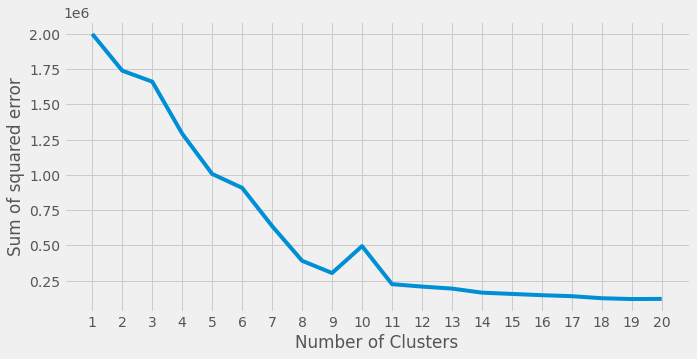

In [72]:
#Let's see if categorical features important for big variance form any meaningful groups 

cols = list(big_var_features[big_var_features['feature'].isin(cat_col_list)]['feature']) + ['TM_ID', 'lt']

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
X_std = sc_x.fit_transform(data_train[cols].fillna(0))

from sklearn.cluster import MiniBatchKMeans

plot_n_clusters = 20
sse = []
for k in range(1, plot_n_clusters+1):
    
        kmeans_batch = MiniBatchKMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10, 
                 max_iter=300, 
                 random_state=1)
        
        kmeans_batch.fit(X_std)
        sse.append(kmeans_batch.inertia_)
        
plt.style.use("fivethirtyeight")
plt.plot(range(1, plot_n_clusters+1), sse)
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.show()

In [73]:
sc_x = StandardScaler()
X_test_std = sc_x.fit_transform(data_test[cols].fillna(0))

from sklearn.cluster import MiniBatchKMeans

kmeans_batch = MiniBatchKMeans(n_clusters=11, 
            init='k-means++', 
            n_init=10,
            max_iter=300, 
            tol=1e-04,
            random_state=1)


y_kmeans_batch_train = kmeans_batch.fit_predict(X_std)

y_kmeans_batch_test = kmeans_batch.predict(X_test_std)

data_train = data_train.assign(cluster = y_kmeans_batch_train)
data_test = data_test.assign(cluster = y_kmeans_batch_test)

del X_std, X_test_std,y_kmeans_batch_train,y_kmeans_batch_test


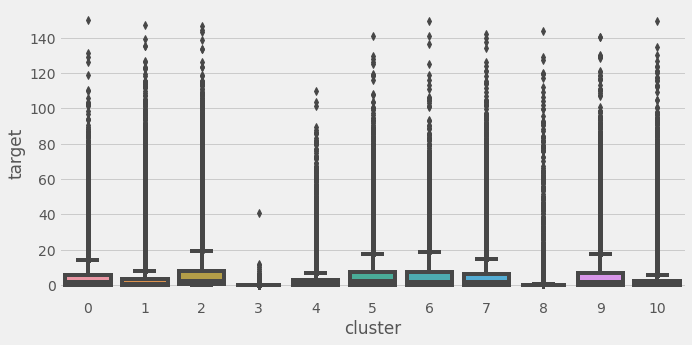

In [74]:
ax = sns.boxplot(x = 'cluster', y = 'target', data=data_train)


In [75]:
# Another feature, important both in general model and big traffic variance prediction is: 

data_train['non_accum_internet_vol_mea_mnt3'].describe()

count    2.491350e+05
mean     7.129124e+16
std               inf
min      0.000000e+00
25%      8.806175e+11
50%      6.414713e+13
75%      2.166495e+15
max      2.182766e+20
Name: non_accum_internet_vol_mea_mnt3, dtype: float64

In [76]:
#Let's create logariphmic bins in order to be able to compare it to the target

symlog = data_train['non_accum_internet_vol_mea_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_train = data_train.assign(non_accum_internet_vol_mea_mnt3_log = symlog)

symlog = data_test['non_accum_internet_vol_mea_mnt3'].apply(lambda x: -np.log10(-x) if x < 0 else np.log10(x) if x > 0 else 0)
data_test = data_test.assign(non_accum_internet_vol_mea_mnt3_log = symlog)

data_train = data_train.assign(non_accum_internet_vol_mea_mnt3_log_bins = pd.cut(data_train['non_accum_internet_vol_mea_mnt3_log'], 
                                                                                bins=range(0, 21)))

data_test = data_test.assign(non_accum_internet_vol_mea_mnt3_log_bins = pd.cut(data_test['non_accum_internet_vol_mea_mnt3_log'], 
                                                                                bins=range(0, 21)))

del symlog

In [77]:
 def ratio_diagram(df, values_col, index_col, columns_cols, comparison_names, agg_func = 'count') :
        
    pivot_df = pd.pivot_table(df, 
                              values=values_col,
                              index=index_col,
                              columns=columns_cols, 
                              aggfunc=agg_func)
    
    pivot_df.columns = comparison_names
    pivot_df = pivot_df.assign(ratio = pivot_df[comparison_names[1]]/pivot_df[comparison_names[0]])


    pivot_df.sort_values(by = 'ratio', ascending = False)

    ax1 = pivot_df.loc[:, comparison_names].plot(kind = 'bar',
                                                 figsize = (10,5),
                                                 rot = 90,
                                                 sharex = True)


    ax1 = pivot_df['ratio'].plot(secondary_y=True,
                                 colormap = 'ocean',
                                 rot = 90,
                                 legend = True,
                                 sharex = True);
    
    plt.show()
    
    return pivot_df
    
    

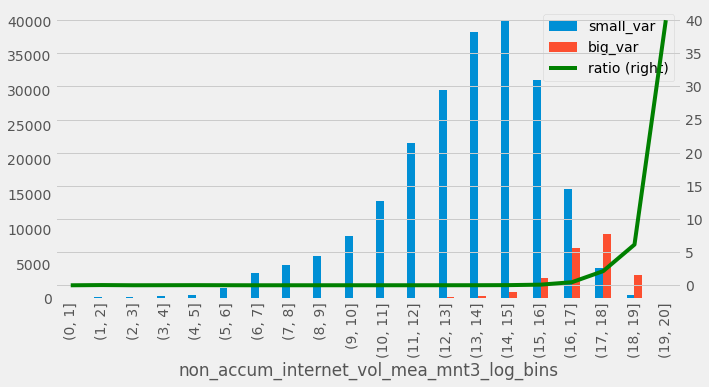

In [78]:
# For big 'non_accum_internet_vol_mea_mnt3' values there are considerably more records with big traffic variance, 
# than with small variance

ratio_df = ratio_diagram(data_train, 
                         ['abon_id'], 
                         ['non_accum_internet_vol_mea_mnt3_log_bins'], 
                         ['big_var'], 
                         ['small_var', 'big_var'])

<Figure size 864x720 with 0 Axes>

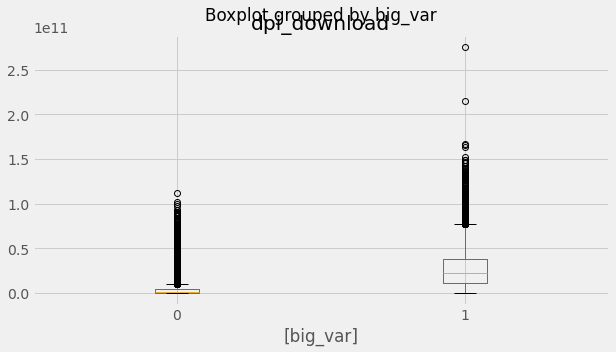

In [85]:
#dpi_download value for bid variance records is considerably bigger and much more spred out
# while for small variance it is concentrated around zero values
plt.figure(figsize=(12,10))
data_train.boxplot(column='dpi_download', by=['big_var']);


### 4. Modelling

In [86]:
data_train.columns

Index(['abon_id', 'Balance_uah', 'TM_ID', 'lt', 'CALCULATION_METHOD_ID',
       'device_days_usage', 'device_brand_samsung', 'device_brand_nokia',
       'device_brand_lenovo', 'device_brand_apple', 'device_brand_huawei',
       'device_brand_lg', 'device_brand_xiaomi', 'device_brand_meizu',
       'device_brand_prestigio', 'device_brand_sony', 'device_brand_nan',
       'device_brand_other', 'device_android_version', 'device_ios_version',
       'device_has_gprs', 'device_has_wifi', 'device_has_lte',
       'device_width_mm', 'device_height_mm', 'device_type_modem',
       'device_type_module', 'device_type_phone', 'device_type_smartphone',
       'device_type_tablet', 'device_type_nan', 'device_type_rus_other',
       'device_sim_count', 'device_price', 'loc_cnt_events',
       'loc_is_obl_center', 'loc_lat', 'loc_lon', 'loc_market_share',
       'bs_of_succ_but_drop_m1', 'bs_of_succ_m1',
       'bs_of_unsucc_attemp_equip_m1', 'bs_of_unsucc_low_balance_m1',
       'bs_of_attemps_all_

In [87]:
data_train_model = data_train.drop(['non_accum_internet_vol_mea_mnt3_log_bins'], axis=1)
data_test_model = data_test.drop(['non_accum_internet_vol_mea_mnt3_log_bins'], axis=1)

In [88]:
X_train, y_train = data_train.drop(['target', 'non_accum_internet_vol_mea_mnt3_log_bins'], axis=1), data_train.target
X_test, y_test = data_test.drop(['target', 'non_accum_internet_vol_mea_mnt3_log_bins'], axis=1), data_test.target

In [89]:
params = {'objective':'regression', 'random_state': 0 }


Let's see if any of the generated features improved the base model

In [90]:
model = ltb.LGBMRegressor(**params)


model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train, y_train_pred, squared = False),
        mean_squared_error(y_test, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

RMSE train: 7.539440, test: 8.643738
R^2 train: 0.596577, test: 0.448154


In [91]:
f_importance_df = pd.DataFrame(model.feature_importances_, X_train.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)
# f_importance_df.sort_index()

,importance
traff_m1,147
traff_m5,64
interc_traff,58
traff_m4,39
bs_succ_rate,36
var,35
myvf_day_usage,34
dpi_upload,31
non_accum_internet_vol_mea_mnt3,31
non_accum_internet_vol_min_mnt3,30


well ,they did by 0.01 and they are among 20 most important ones. 
Let's try different models by big var feature

In [92]:
#DIFFERENT MODELS BY BIG VAR

X_list, y_list = [], []
models = []

for g, v in data_train_model.groupby('big_var'):
        
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    

y_train_pred, y_train  = pd.Series(), pd.Series()

for X_tr, y_tr in zip(X_list, y_list): 

    model = ltb.LGBMRegressor(**params)

    model.fit(X_tr, y_tr)
    
    train_pred = pd.Series(data = model.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)        
    y_train = y_train.append(y_tr)
    models.append(model)
   
    
    print('big_var == ' +str(X_tr['big_var'].unique()[0])+' set results')
    print()

    print('RMSE:{:.6f}'.format(mean_squared_error(y_tr, train_pred, squared = False)))
    print('R^2: {:.6f}'.format(r2_score(y_tr, train_pred)))
    print()
    
    joblib_file = "joblib_model"+"big_var_"+str(int(X_tr['big_var'].unique()[0]))+".pkl"
    joblib.dump(model, joblib_file)

print('RMSE train TOTAL: {:.6f}'.format(mean_squared_error(y_train, y_train_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}'.format(r2_score(y_train, y_train_pred)))
        

big_var == 0 set results

RMSE:5.259144
R^2: 0.570108

big_var == 1 set results

RMSE:16.131231
R^2: 0.532637

RMSE train TOTAL: 7.135485
R^2 train TOTAL: 0.638649


In [93]:
#DIFFERENT MODELS BY VAR TEST SET

X_list, y_list = [], []

for g, v in data_test_model.groupby('big_var'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)   

y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in zip(X_list, y_list):
    
    joblib_file = "joblib_model"+"big_var_"+str(int(X_ts['big_var'].unique()[0]))+".pkl"
    model = joblib.load(joblib_file)    

    test_test_pred = pd.Series(data = model.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    y_test_test = y_test_test.append(y_ts) 
    
    print()
    print(str(X_ts['big_var'].unique()[0])+' set results')
    print()

    print('RMSE test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 test: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))  
    
    
   
print()

print('RMSE test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))
    
   


0 set results

RMSE test: 6.195459
R^2 test: 0.443188

1 set results

RMSE test: 20.123765
R^2 test: 0.213040

RMSE test TOTAL: 8.662683
R^2 test TOTAL: 0.445733


In [94]:
f_importance_df = pd.DataFrame(model.feature_importances_, X_train.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)
# f_importance_df.sort_index()

,importance
traff_m1,116
traff_m5,47
interc_traff,43
bs_succ_rate,36
dpi_upload,30
traff_m4,29
loc_lon,29
non_accum_internet_vol_mea_mnt3,28
non_accum_internet_vol_min_mnt3,23
var,22


In [95]:
f_importance_df = pd.DataFrame(models[1].feature_importances_, X_train.columns, columns=['importance'])
f_importance_df.sort_values(by='importance', ascending=False)
# f_importance_df.sort_index()

,importance
traff_m1,116
traff_m5,47
interc_traff,43
bs_succ_rate,36
dpi_upload,30
traff_m4,29
loc_lon,29
non_accum_internet_vol_mea_mnt3,28
non_accum_internet_vol_min_mnt3,23
var,22


Model has not improved comparing to the full dataset one, but intercept, slope_traff and var are among top 10 for the big traffic variance model results. Let's see if hyper parameter tuning will influence the score

### 4. Model validation and hyperparameter tuning

In [ ]:
# # # CV FOR FULL DATASET MODEL

data_train_model_bv1 = data_train[data_train_model['big_var'] == 1]
X_train = data_train_model_bv1.drop(['target', 'non_accum_internet_vol_mea_mnt3_log_bins'], axis=1)
y_train = data_train_model_bv1.target

n_folds = 3

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

parameters = {'learning_rate': [0.03],
              'n_estimators': [350],
              'reg_alpha':[0.55],
              'reg_lambda':[0.2, 0.21, 0.22, 0.23, 0.24, 0.25],
              'num_leaves': [20],
              'subsample_for_bin': [60000]}


lgbm = LGBMRegressor(silent=True, random_state= 3)
n_iter_search = 20

# grid_search = GridSearchCV(lgbm, parameters, scoring=scoring, n_jobs=-1, cv=kf, verbose = True)
random_search = RandomizedSearchCV(lgbm, 
                                   param_distributions=parameters,
                                   n_iter=n_iter_search,
                                   scoring=scoring, 
                                   n_jobs=-1, 
                                   cv=kf, 
                                   verbose = True)
res = random_search.fit(X_train, y_train)

del data_train_model_bv1

print(res)

print(f'Best score: {random_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = random_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')


In [ ]:
X_train = data_train_model.drop(['target'], axis=1)
y_train = data_train_model.target

n_folds = 5

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

parameters = {'learning_rate': [0.05, 0.1, 0.2],
              'n_estimators': [200, 400],
              'num_leaves': [10, 50, 100],
              'reg_alpha': [0.05, 0.7],
              'subsample_for_bin': [50000, 200000]}


lgbm = LGBMRegressor(silent=True, random_state= 3)
n_iter_search = 20

random_search = RandomizedSearchCV(lgbm, 
                                   param_distributions=parameters,
                                   n_iter=n_iter_search,
                                   scoring=scoring, 
                                   n_jobs=-1, 
                                   cv=kf, 
                                   verbose = True)
res = random_search.fit(X_train, y_train)

del data_train_model_bv1

print(res)

print(f'Best score: {random_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = random_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [ ]:
data_train_model_bv0 = data_train[data_train_model['big_var'] == 0]
X_train = data_train_model_bv0.drop(['target', 'non_accum_internet_vol_mea_mnt3_log_bins'], axis=1)
y_train = data_train_model_bv0.target

n_folds = 3

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

param_distributions={'learning_rate': [0.03, 0.05, 0.07],
                     'n_estimators': [300, 400, 500],
                     'num_leaves': [20, 30],
                     'reg_alpha': [0.5, 0.6, 0.7],
                     'subsample_for_bin': [50000, 100000]}


lgbm = LGBMRegressor(silent=True, random_state= 3)
n_iter_search = 20

# grid_search = GridSearchCV(lgbm, parameters, scoring=scoring, n_jobs=-1, cv=kf, verbose = True)
random_search = RandomizedSearchCV(lgbm, 
                                   param_distributions=parameters,
                                   n_iter=n_iter_search,
                                   scoring=scoring, 
                                   n_jobs=-1, 
                                   cv=kf, 
                                   verbose = True)
res = random_search.fit(X_train, y_train)

del data_train_model_bv0
print(res)

print(f'Best score: {random_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = random_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

In [ ]:
# TOTAL SET 

# RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
#                    estimator=LGBMRegressor(random_state=3), n_iter=20,
#                    n_jobs=-1,
#                    param_distributions={'learning_rate': [0.05, 0.1, 0.2],
#                                         'n_estimators': [200, 400],
#                                         'num_leaves': [10, 50, 100],
#                                         'reg_alpha': [0.05, 0.7],
#                                         'subsample_for_bin': [50000, 200000]},
#                    scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
#                    verbose=True)
# Best parameters set:
# 	learning_rate:  0.05
# 	n_estimators:  400
# 	num_leaves:  10
# 	reg_alpha:  0.7
# 	subsample_for_bin:  50000

# Big_var == 0 
# RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
#                    estimator=LGBMRegressor(random_state=3), n_iter=20,
#                    n_jobs=-1,
#                    param_distributions={'learning_rate': [0.03, 0.05, 0.07],
#                                         'n_estimators': [300, 400, 500],
#                                         'num_leaves': [20, 30],
#                                         'reg_alpha': [0.5, 0.6, 0.7],
#                                         'subsample_for_bin': [50000, 100000]},
#                    scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
#                    verbose=True)

# Best parameters set:
# 	learning_rate:  0.03
# 	n_estimators:  400
# 	num_leaves:  20
# 	reg_alpha:  0.7
# 	subsample_for_bin:  50000

# Big_var == 0 
# RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
#                    estimator=LGBMRegressor(random_state=3), n_iter=20,
#                    n_jobs=-1,
#                    param_distributions={'learning_rate': [0.03],
#                                         'n_estimators': [350],
#                                         'num_leaves': [20], 'reg_alpha': [0.55],
#                                         'reg_lambda': [0.2, 0.21, 0.22, 0.23,
#                                                        0.24, 0.25],
#                                         'subsample_for_bin': [60000]},
#                    scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
#                    verbose=True)
# Best score: -19.960539741921377 

# Best parameters set:
# 	learning_rate:  0.03
# 	n_estimators:  350
# 	num_leaves:  20
# 	reg_alpha:  0.55
# 	reg_lambda:  0.25
# 	subsample_for_bin:  60000

In [ ]:
#DIFFERENT MODELS BY BIG VAR

X_list, y_list = [], []
models = []

params_dict = {'0':{'objective':'regression', 'random_state': 0, 'learning_rate':0.03, 'n_estimators':400, 'reg_alpha': 0.7, 
                   'num_leaves':20, 'subsample_for_bin':50000}, 
               '1':{'objective':'regression', 'random_state': 0,'learning_rate':0.03, 'n_estimators':350, 'reg_alpha': 0.55,
                   'num_leaves':20, 'reg_lambda':0.25, 'subsample_for_bin':50000}}

for g, v in data_train_model.groupby('big_var'):
        
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    

y_train_pred, y_train  = pd.Series(), pd.Series()

for X_tr, y_tr in zip(X_list, y_list): 
    
    params = params_dict.get(str(int(X_tr['big_var'].unique()[0])))

    model = ltb.LGBMRegressor(**params)

    model.fit(X_tr, y_tr)
    
    train_pred = pd.Series(data = model.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)        
    y_train = y_train.append(y_tr)
    models.append(model)
   
    
    print('big_var == ' +str(X_tr['big_var'].unique()[0])+' set results')
    print()

    print('RMSE:{:.6f}'.format(mean_squared_error(y_tr, train_pred, squared = False)))
    print('R^2: {:.6f}'.format(r2_score(y_tr, train_pred)))
    print()
    
    joblib_file = "joblib_model"+"big_var_"+str(int(X_tr['big_var'].unique()[0]))+".pkl"
    joblib.dump(model, joblib_file)

print('RMSE train TOTAL: {:.6f}'.format(mean_squared_error(y_train, y_train_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}'.format(r2_score(y_train, y_train_pred)))
        

In [ ]:
#DIFFERENT MODELS BY VAR TEST SET

X_list, y_list = [], []

for g, v in data_test_model.groupby('big_var'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)   

y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in zip(X_list, y_list):
    
    joblib_file = "joblib_model"+"big_var_"+str(int(X_ts['big_var'].unique()[0]))+".pkl"
    model = joblib.load(joblib_file)    

    test_test_pred = pd.Series(data = model.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    y_test_test = y_test_test.append(y_ts) 
    
    print()
    print(str(X_ts['big_var'].unique()[0])+' set results')
    print()

    print('RMSE test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 test: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))  
    
    
   
print()

print('RMSE test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))    
   

Since variance seems to be one of the most important predictors, let's fill out missing values for other important features, grouping them by variance quantile. Median seems to be more preferable since values in almost all columns have huge tails

In [ ]:
f_importance_df1 = pd.DataFrame(models[1].feature_importances_, X_train.columns, columns=['importance'])
f_importance_df0 = pd.DataFrame(models[0].feature_importances_, X_train.columns, columns=['importance'])
total_f_importance = f_importance_df1.merge(f_importance_df0,
                                            right_index=True,
                                            left_index=True,
                                            how='outer',
                                            suffixes = ['_m1', '_m0'])

total_f_importance = total_f_importance.assign(total_importance = total_f_importance['importance_m1'] + 
                                                                  total_f_importance['importance_m0'])

cols_to_fill_na = list(total_f_importance[total_f_importance['total_importance'] > 0].index)
print(len(cols_to_fill_na))

cat_col_list = cat_col_list + ['TM_ID', 'abon_id']

cols_to_fill_na = [x for x in cols_to_fill_na if x not in cat_col_list]
print(len(cols_to_fill_na))

data_train_temp = data_train.copy()
# print(data_train_temp[cols_to_fill_na].isna().sum())

for col in cols_to_fill_na: 
    data_train[[col]] = data_train[[col] + ['big_var']].groupby('big_var').transform(lambda x: x.fillna(x.median()))
    
    data_test[[col]] = data_test[[col] + ['big_var']].groupby('big_var').transform(lambda x: x.fillna(x.median()))
    
    
print(data_train[cols_to_fill_na].isna().sum())

In [ ]:
data_train_model = data_train.drop(['non_accum_internet_vol_mea_mnt3_log_bins'], axis=1).fillna(0)
data_test_model = data_test.drop(['non_accum_internet_vol_mea_mnt3_log_bins'], axis=1).fillna(0)

X_train, y_train = data_train.drop(['target', 'non_accum_internet_vol_mea_mnt3_log_bins'], axis=1), data_train.target
X_test, y_test = data_test.drop(['target', 'non_accum_internet_vol_mea_mnt3_log_bins'], axis=1), data_test.target

In [ ]:
#DIFFERENT MODELS BY BIG VAR

X_list, y_list = [], []
models = []

params_dict = {'0':{'objective':'regression', 'random_state': 0, 'learning_rate':0.03, 'n_estimators':400, 'reg_alpha': 0.7, 
                   'num_leaves':20, 'subsample_for_bin':50000}, 
               '1':{'objective':'regression', 'random_state': 0,'learning_rate':0.03, 'n_estimators':350, 'reg_alpha': 0.55,
                   'num_leaves':20, 'reg_lambda':0.25, 'subsample_for_bin':50000}}

for g, v in data_train_model.groupby('big_var'):
        
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    

y_train_pred, y_train  = pd.Series(), pd.Series()

for X_tr, y_tr in zip(X_list, y_list): 
    
    params = params_dict.get(str(int(X_tr['big_var'].unique()[0])))

    model = ltb.LGBMRegressor(**params)

    model.fit(X_tr, y_tr)
    
    train_pred = pd.Series(data = model.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)        
    y_train = y_train.append(y_tr)
    models.append(model)
   
    
    print('big_var == ' +str(X_tr['big_var'].unique()[0])+' set results')
    print()

    print('RMSE:{:.6f}'.format(mean_squared_error(y_tr, train_pred, squared = False)))
    print('R^2: {:.6f}'.format(r2_score(y_tr, train_pred)))
    print()
    
    joblib_file = "joblib_model"+"big_var_"+str(int(X_tr['big_var'].unique()[0]))+".pkl"
    joblib.dump(model, joblib_file)

print('RMSE train TOTAL: {:.6f}'.format(mean_squared_error(y_train, y_train_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}'.format(r2_score(y_train, y_train_pred)))
        

In [ ]:
#DIFFERENT MODELS BY VAR TEST SET

X_list, y_list = [], []

for g, v in data_test_model.groupby('big_var'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)   

y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in zip(X_list, y_list):
    
    joblib_file = "joblib_model"+"big_var_"+str(int(X_ts['big_var'].unique()[0]))+".pkl"
    model = joblib.load(joblib_file)    

    test_test_pred = pd.Series(data = model.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    y_test_test = y_test_test.append(y_ts) 
    
    print()
    print(str(X_ts['big_var'].unique()[0])+' set results')
    print()

    print('RMSE test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 test: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))  
    
    
   
print()

print('RMSE test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))    
   

Filling out missings with median by traffic variance quantiles worsened the score of the model. Probably NaNs are imporatant for the model as they are 

Also, since traffic variance is an important feature, lets' explore if big traffic linregress slope focuses the model error even more 

In [ ]:
data_train_model = data_train.drop(['non_accum_internet_vol_mea_mnt3_log_bins'], axis=1).fillna(0)
data_test_model = data_test.drop(['non_accum_internet_vol_mea_mnt3_log_bins'], axis=1).fillna(0)

X_train, y_train = data_train.drop(['target', 'non_accum_internet_vol_mea_mnt3_log_bins'], axis=1), data_train.target
X_test, y_test = data_test.drop(['target', 'non_accum_internet_vol_mea_mnt3_log_bins'], axis=1), data_test.target

In [ ]:
#DIFFERENT MODELS BY BIG SLOPE

X_list, y_list = [], []
models = []

params_dict = {'0':{'objective':'regression', 'random_state': 0, 'learning_rate':0.03, 'n_estimators':400, 'reg_alpha': 0.7, 
                   'num_leaves':20, 'subsample_for_bin':50000}, 
               '1':{'objective':'regression', 'random_state': 0,'learning_rate':0.03, 'n_estimators':350, 'reg_alpha': 0.55,
                   'num_leaves':20, 'reg_lambda':0.25, 'subsample_for_bin':50000}}

for g, v in data_train_model.groupby('bsl_TM_ID'):
        
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    

y_train_pred, y_train  = pd.Series(), pd.Series()

for X_tr, y_tr in zip(X_list, y_list): 
    
    params = params_dict.get(str(int(X_tr['bsl_TM_ID'].unique()[0])))

    model = ltb.LGBMRegressor(**params)

    model.fit(X_tr, y_tr)
    
    train_pred = pd.Series(data = model.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)        
    y_train = y_train.append(y_tr)
    models.append(model)
   
    
    print('bsl_TM_ID == ' +str(X_tr['bsl_TM_ID'].unique()[0])+' set results')
    print()

    print('RMSE:{:.6f}'.format(mean_squared_error(y_tr, train_pred, squared = False)))
    print('R^2: {:.6f}'.format(r2_score(y_tr, train_pred)))
    print()
    
    joblib_file = "joblib_model"+"bsl_TM_ID_"+str(int(X_tr['bsl_TM_ID'].unique()[0]))+".pkl"
    joblib.dump(model, joblib_file)

print('RMSE train TOTAL: {:.6f}'.format(mean_squared_error(y_train, y_train_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}'.format(r2_score(y_train, y_train_pred)))
        

In [ ]:
#DIFFERENT MODELS BY SLOPE TEST SET

X_list, y_list = [], []

for g, v in data_test_model.groupby('bsl_TM_ID'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)   

y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in zip(X_list, y_list):
    
    joblib_file = "joblib_model"+"bsl_TM_ID_"+str(int(X_ts['bsl_TM_ID'].unique()[0]))+".pkl"
    model = joblib.load(joblib_file)    

    test_test_pred = pd.Series(data = model.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    y_test_test = y_test_test.append(y_ts) 
    
    print()
    print(str(X_ts['bsl_TM_ID'].unique()[0])+' set results')
    print()

    print('RMSE test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 test: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))
    
print()

print('RMSE test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))    
   